# Module Association with Outcome

**Created**: 20 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("survival")) {
    install.packages("survival")
}

# If this fails, install directly to conda environment
#   conda install r-survminer -c conda-forge
# if (!requireNamespace("survminer")) {
#     install.packages("survminer")
# }

if (!requireNamespace("lubridate")) {
    install.packages("lubridate")
}

Loading required namespace: patchwork

Loading required namespace: survival

Loading required namespace: lubridate



In [2]:
library(tidyverse)
library(RColorBrewer)
library(patchwork)
library(survival)
library(survminer)
library(lubridate)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




## Load Data

In [3]:
outcome <- read.table("/nfs/team282/data/gains_team282/ClinicalData/clinical_data_tsv/OUT_12jun2019.tsv", sep="\t", header=T, quote="")

outcome <- outcome %>%
    dplyr::mutate(GAinSID=stringr::str_to_upper(SubjectBarCode))
ga.prefix.filter <- grepl("GA", outcome$GAinSID)
outcome$GAinSID[ga.prefix.filter] <- gsub("^GA", "", outcome$GAinSID[ga.prefix.filter])
rownames(outcome) <- outcome$GAinSID

modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)
variance.explained <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv")

sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt")
ga.prefix.filter <- grepl("GA", sample.info$supplier_name)
sample.info$supplier_name[ga.prefix.filter] <- gsub("^GA", "", sample.info$supplier_name[ga.prefix.filter])
sample.info <- sample.info %>% 
    dplyr::filter(supplier_name %in% rownames(eigengenes))
rownames(sample.info) <- sample.info$supplier_name
sample.info <- sample.info[rownames(eigengenes),]
sample.info <- sample.info %>%
    dplyr::mutate(Time.Point=as.numeric(sapply(strsplit(rownames(.), "_"), function(x) x[2])))

## Subset Patients

The same patients have contributed up to three samples to the data (D1, D3, and/or D5). I have decided to choose the last time point available for each patient.

In [4]:
sample.map <- sample.info %>%
    dplyr::filter(GAinSID %in% outcome$GAinSID) %>%
    dplyr::group_by(GAinSID) %>%
    dplyr::summarize(Last.Time.Point=max(Time.Point)) %>%
    dplyr::mutate(Sample=paste0(GAinSID, "_", Last.Time.Point))

cox.eigengenes <- eigengenes[sample.map$Sample,]

cox.outcomes <- outcome[sample.map$GAinSID,]

## Cox Proportional Hazards Model

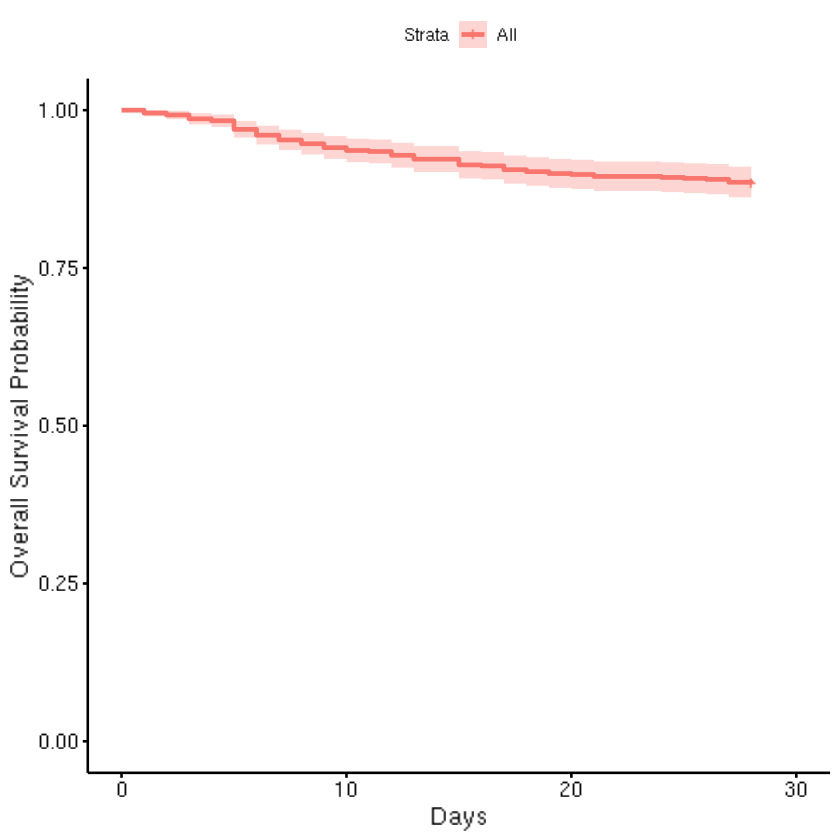

In [5]:
cox.vars <- cox.outcomes %>%
    dplyr::mutate(Date.Hospitalized=lubridate::mdy(DhospICU), Date.Death=lubridate::mdy(M6ddeath)) %>%
    dplyr::mutate(Endpoint=as.duration(Date.Hospitalized %--% Date.Death) / lubridate::ddays(1)) %>%
    dplyr::mutate(Endpoint=replace(Endpoint, Endpoint > 28, NA)) %>%
    dplyr::mutate(Status=ifelse(is.na(Endpoint), 0, 1)) %>%
    dplyr::select(Endpoint, Status) %>%
    dplyr::mutate(Endpoint=replace(Endpoint, is.na(Endpoint), 28)) %>%
    dplyr::bind_cols(cox.eigengenes)

ggsurvplot(
    fit = survfit(Surv(Endpoint, Status) ~ 1, data = cox.vars), 
    xlab = "Days", 
    ylab = "Overall Survival Probability"
)

I use a Cox proportional hazards model to test if a given module eigengene is associated with outcome. I run the model for each eigengene rather than including them all in one regression. I correct p-values using Benjamini-Hochberg FDR correction.

In [7]:
test.results <- list()

for (eigengene in colnames(cox.eigengenes)) {

    cox.result <- coxph(
        as.formula(paste0("Surv(Endpoint, Status)~", eigengene)), 
        data = cox.vars
    )

    test.results[[eigengene]] <- summary(cox.result)$coefficients
}

estimates <- do.call(rbind, test.results) %>%
    as.data.frame() %>%
    dplyr::mutate(Adjusted.P.Value=p.adjust(`Pr(>|z|)`, method="BH")) %>%
    dplyr::arrange(desc(abs(coef)), desc(desc(Adjusted.P.Value))) %>%
    dplyr::mutate(Eigengene=rownames(.), Association.Variable="Outcome", Association.Variable.Type="Outcome", Statistic.Type="Beta") %>%
    dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=coef, Statistic.Type, P.Value=`Pr(>|z|)`, Adjusted.P.Value)
head(estimates %>% dplyr::filter(Adjusted.P.Value < 0.05))

write.csv(estimates, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.outcome.association.csv")

,Eigengene,Association.Variable,Association.Variable.Type,Statistic,Statistic.Type,P.Value,Adjusted.P.Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
ME_78,ME_78,Outcome,Outcome,-18.99438,Beta,2.100379e-05,0.0007421341
ME_36,ME_36,Outcome,Outcome,-17.55320,Beta,4.786730e-05,0.0008456556
ME_52,ME_52,Outcome,Outcome,-16.95356,Beta,3.800128e-05,0.0008056271
ME_10,ME_10,Outcome,Outcome,-15.78185,Beta,2.037898e-05,0.0007421341
ME_47,ME_47,Outcome,Outcome,-15.37841,Beta,1.266732e-05,0.0007421341
ME_13,ME_13,Outcome,Outcome,-14.51251,Beta,1.414622e-04,0.0016661109
